출처 : DATA STATION (https://blog.naver.com/data_station/222493262626)

# 시계열 분석 (Time Series)

* 시간 : 특정 간격 갖는 시간 (Lag)
- Lag 에서 Data 의 Trend 를 찾음


### 시계열 분석 요소

* Trend : 추세
* Seasonality : 계절성
* Cycle : 주기
* Noise : 잡음 (시간에 독립적). 
    - white noise : 분석이 가능한 수준의 잡음

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', family="D2Coding")

In [68]:
df1 = pd.read_csv('example_data/Data11.csv')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803675 entries, 0 to 803674
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   구매일     803675 non-null  object
 1   구매금액    803675 non-null  int64 
 2   물품대분류   803675 non-null  object
dtypes: int64(1), object(2)
memory usage: 18.4+ MB


In [69]:
df1.head()

,구매일,구매금액,물품대분류
0,2018-04-20,57120,기저귀
1,2018-04-20,15900,더블하트
2,2018-04-20,7000,더블하트
3,2018-04-20,20900,더블하트
4,2018-05-06,26500,더블하트


In [70]:
df1.tail() 

,구매일,구매금액,물품대분류
803670,2020-08-06,30960,더블하트
803671,2020-08-06,6640,더블하트
803672,2020-08-06,5600,더블하트
803673,2020-08-06,7840,더블하트
803674,2020-08-06,8500,기타


In [71]:
# 구매일 범위 확인을 위해 구매일 컬럼을 시간 형식으로 변경

df1['Datetime'] = pd.to_datetime(df1['구매일']) 

In [72]:
# Series 에서도 describe 적용 가능
# top - freq 최빈값과 횟수

df1['Datetime'].describe()

/var/folders/kf/qhwz1kl94hb_m0m7sqhlwdm00000gn/T/ipykernel_29754/1972474356.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df1['Datetime'].describe()


count                  803675
unique                    589
top       2019-10-11 00:00:00
freq                    10500
first     2018-04-20 00:00:00
last      2020-08-07 00:00:00
Name: Datetime, dtype: object

In [73]:
# 시간 형식으로 변형된 데이터를 통해 변수 파생

df1['Year'] = df1['Datetime'].dt.year
df1['Month'] = df1['Datetime'].dt.month
df1['Week'] = df1['Datetime'].dt.week
df1['Day_of_week'] = df1['Datetime'].dt.day_name()

/var/folders/kf/qhwz1kl94hb_m0m7sqhlwdm00000gn/T/ipykernel_29754/2287290761.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df1['Week'] = df1['Datetime'].dt.week


In [74]:
df1.head()

,구매일,구매금액,물품대분류,Datetime,Year,Month,Week,Day_of_week
0,2018-04-20,57120,기저귀,2018-04-20,2018,4,16,Friday
1,2018-04-20,15900,더블하트,2018-04-20,2018,4,16,Friday
2,2018-04-20,7000,더블하트,2018-04-20,2018,4,16,Friday
3,2018-04-20,20900,더블하트,2018-04-20,2018,4,16,Friday
4,2018-05-06,26500,더블하트,2018-05-06,2018,5,18,Sunday


<AxesSubplot:xlabel='Datetime', ylabel='구매금액'>

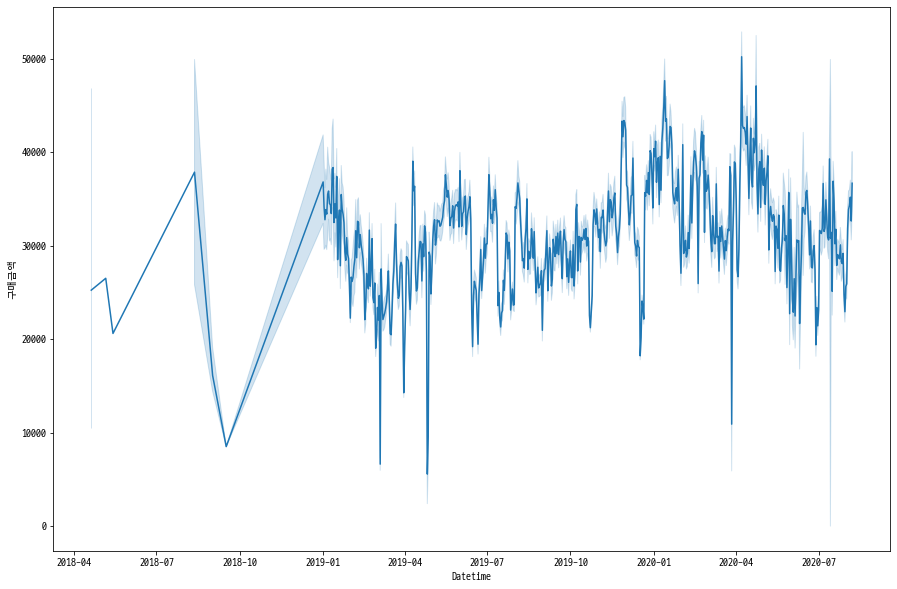

In [75]:
# 해당 날짜의 구매 금액 평균
sns.lineplot(data=df1, x='Datetime', y='구매금액')

<AxesSubplot:xlabel='Datetime', ylabel='구매금액'>

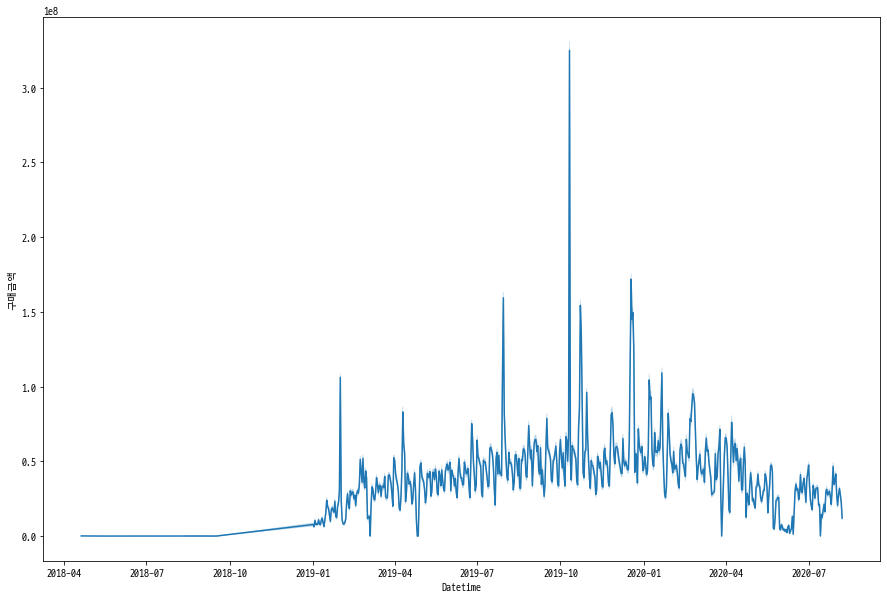

In [76]:
# 해당 날짜의 구매 금액 총합
sns.lineplot(data=df1, x='Datetime', y='구매금액', estimator=sum)

In [77]:
# pivot 을 활용해서 그리기 -> lineplot 자체에서 계산하면 너무 오래걸리기 때문

p1 = pd.pivot_table(data=df1, 
index='Datetime', 
values='구매금액', 
aggfunc='sum').reset_index()

In [78]:
p1.head()

,Datetime,구매금액
0,2018-04-20,100920
1,2018-05-06,26500
2,2018-05-14,20600
3,2018-08-12,75700
4,2018-09-01,48300


<AxesSubplot:xlabel='Datetime', ylabel='구매금액'>

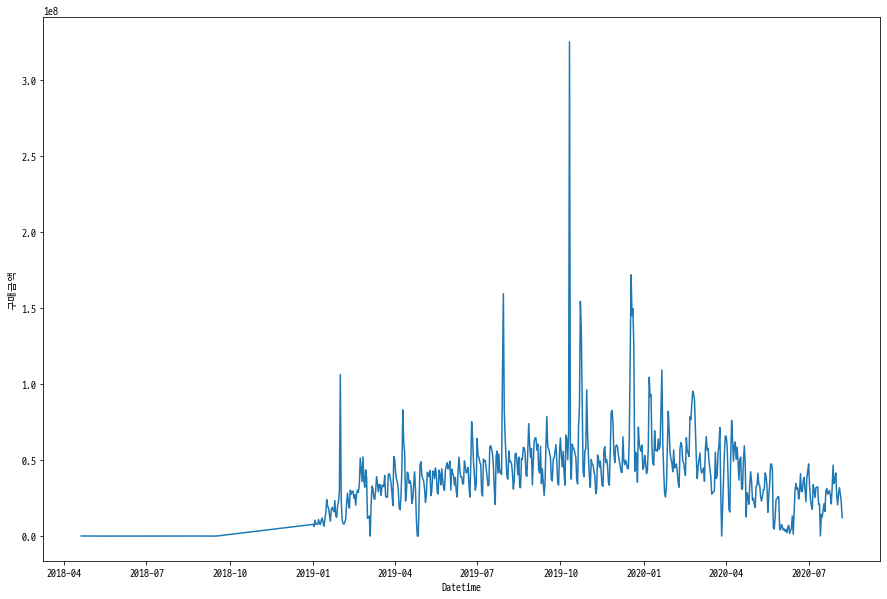

In [79]:
sns.lineplot(data=p1, x='Datetime', y='구매금액')

In [80]:
p2 = pd.pivot_table(data=df1, 
index= ['Datetime', '물품대분류'], 
values='구매금액', 
aggfunc='sum').reset_index()

In [81]:
p2.head()

,Datetime,물품대분류,구매금액
0,2018-04-20,기저귀,57120
1,2018-04-20,더블하트,43800
2,2018-05-06,더블하트,26500
3,2018-05-14,FC,20600
4,2018-08-12,더블하트,75700


<AxesSubplot:xlabel='Datetime', ylabel='구매금액'>

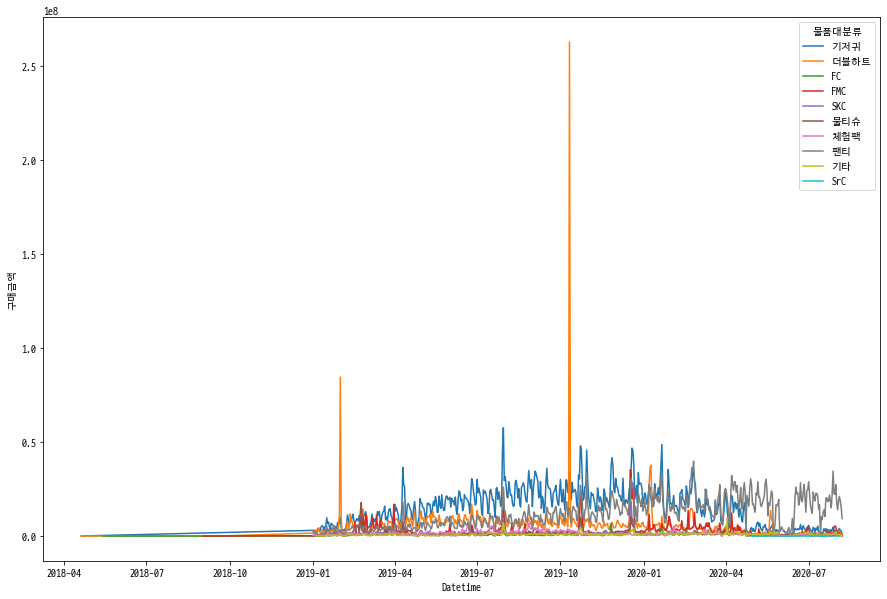

In [82]:
sns.lineplot(data=p2, x='Datetime', y='구매금액', hue='물품대분류')

# [해설] 더블하트 급상승과 같은 요소는 특별한 이벤트에 의해 발생. 이후 예측에 영향을
# 끼치게 되면 예측력을 떨어뜨리므로 이를 방지하기 위해 이벤트를 제외하는 것이 좋다.

In [83]:
# 물품대분류 == '기저귀'인 경우

cond1 = (df1['물품대분류']=='기저귀')
df2 = df1.loc[cond1].iloc[1:] # 2018-04-20 이후 한동안 데이터가 없다는 것을 확인 -> 데이터 삭제
df2.head()

,구매일,구매금액,물품대분류,Datetime,Year,Month,Week,Day_of_week
29,2019-05-13,59520,기저귀,2019-05-13,2019,5,20,Monday
30,2019-05-10,50640,기저귀,2019-05-10,2019,5,19,Friday
31,2019-06-06,50640,기저귀,2019-06-06,2019,6,23,Thursday
32,2019-07-01,50640,기저귀,2019-07-01,2019,7,27,Monday
33,2019-07-29,101280,기저귀,2019-07-29,2019,7,31,Monday


## ARIMA (Auto Regressive Integrated Moving Average Model)

* ARIMA = AR + MA + Difference
    * AR (Auto Regressive Model) : 자기 회귀 모델. p 시점 전의 자료가 현재 시점 데이터에 영향
        * ACF (AutoCorreltion Function) : 자기상관함수. 특정 구간 내 데이터 간 상관관계
        * PACF (Partial AutoCorreltion Function) : 부분자기상관함수. 과거 데이터가 지속적으로 영향을 주는 문제 보완
    * MA (Moving Average Model) : 이동 평균 모델. 일정한 구간 데이터의 평균을 계산해, 미래를 예측하는 모델 -> AR만 활용했을 때의 불규칙한 변동 제거
    *   Difference : 차분. 정상성을 만족하지 못하는 데이터(ex. 평균이 증가, 분산이 감소)를 정상적으로 변환

#
* ARIMA 활용 조건
    * 단기 예측에 적합
    * 계절적 변동 요인 (주기적 변동)
    * Sample > 50
    * 정상적 자료 <- 차분
        * 정상성(Stationarity) : 시계열의 평균과 분산 일정. 특정한 트렌드가 존재하지 않는 성질

In [84]:
import statsmodels.tsa.api as tsa

In [85]:
df2.head()

,구매일,구매금액,물품대분류,Datetime,Year,Month,Week,Day_of_week
29,2019-05-13,59520,기저귀,2019-05-13,2019,5,20,Monday
30,2019-05-10,50640,기저귀,2019-05-10,2019,5,19,Friday
31,2019-06-06,50640,기저귀,2019-06-06,2019,6,23,Thursday
32,2019-07-01,50640,기저귀,2019-07-01,2019,7,27,Monday
33,2019-07-29,101280,기저귀,2019-07-29,2019,7,31,Monday


In [86]:
df_time = pd.pivot_table(data=df2, 
index='Datetime', 
values='구매금액', 
aggfunc='sum')

## Datetime이 인덱스로 잡혀있는게 분석할 때 편리!
#df_time = pd.pivot_table(data=df2, 
#index='Datetime', 
#values='구매금액', 
#aggfunc='sum').reset_index()
#df_time.set_index('Datetime')

df_time.head()

,구매금액
Datetime,
2019-01-01,3051240
2019-01-02,2556280
2019-01-03,2729480
2019-01-04,2238440
2019-01-05,2478680


In [87]:
# 일주일 단위의 평균 금액 계산
y = df_time['구매금액'].resample('1D').mean()

In [88]:
# 결측값 확인
y.isnull().sum()

7

In [89]:
# 결측값 있을 시 시계열에서는 
y1 = y.fillna( method='ffill' ) # method 'bfill' 또는 'ffill'

### 시계열 분해
* Trend (추세 요인)
* Seasonality (계절 요인)
* Residual (불규칙 또는 순환 요인)

In [90]:
# 테이블 크기 조정

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

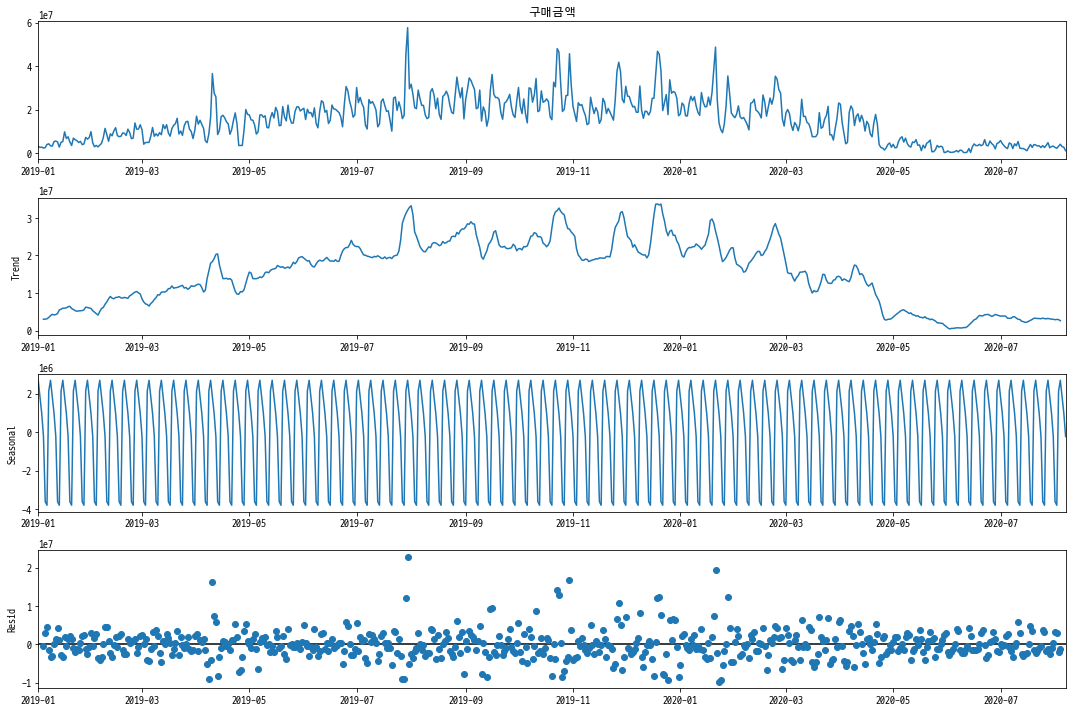

In [91]:
# 시계열 모델 생성
model_series = tsa.seasonal_decompose(y1, model='additive')

# 모델 시각화
fig = model_series.plot()
plt.show()

In [92]:
import itertools

In [93]:
p = d = q = range(0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))

SARIMAX: (0, 0, 1) x (0, 0, 1, 12)


In [94]:
param_list = []
param_seasonal_list = []
results_AIC_list = []

for param in pdq:
     for param_seasonal in seasonal_pdq:
        try:
            model = tsa.statespace.SARIMAX(y1,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
            results = model.fit()
            param_list.append(param)
            param_seasonal_list.append(param_seasonal)
            results_AIC_list.append(results.aic)
        except:
             continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81070D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   1.811D+01
  F =   18.106959300286004     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70055D+01    |proj g|=  2.48676D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.487D-09   1.701D+01
  F =   17.005458439900412     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.6

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65802D+01    |proj g|=  5.99556D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.996D-06   1.658D+01
  F =   16.580170444073588     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64939D+01    |proj g|=  7.11214D-02

At iterate    5    f=  1.64824D+01    |proj g|=  5.45484D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     10      1     0     0   2.935D-07   1.648D+01
  F =   16.482411165458114     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77545D+01    |proj g|=  1.14888D+00

At iterate    5    f=  1.77270D+01    |proj g|=  6.99174D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      9      1     0     0   4.675D-07   1.773D+01
  F =   17.727014305591336     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67649D+01    |proj g|=  2.06157D-01

At iterate    5    f=  1.67563D+01    |proj g|=  2.13163D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   2.132D-07   1.676D+01
  F =   16.756250403541760     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62598D+01    |proj g|=  1.47715D-01

At iterate    5    f=  1.62531D+01    |proj g|=  2.16858D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   2.169D-05   1.625D+01
  F =   16.253144838627595     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.72295D+01    |proj g|=  3.96670D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   2.668D-06   1.723D+01
  F =   17.229462934397031     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63704D+01    |proj g|=  1.68915D-01

At iterate    5    f=  1.63639D+01    |proj g|=  1.91167D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62729D+01    |proj g|=  1.89498D-01

At iterate    5    f=  1.62517D+01    |proj g|=  1.32145D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   4.655D-06   1.625D+01
  F =   16.251535502588276     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68666D+01    |proj g|=  7.10570D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   7.106D-10   1.687D+01
  F =   16.866630979254030     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.6

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63264D+01    |proj g|=  2.27042D-01

At iterate    5    f=  1.62676D+01    |proj g|=  6.18666D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     29      1     0     0   5.796D-06   1.627D+01
  F =   16.267615911879773     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65527D+01    |proj g|=  4.93472D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.935D-06   1.655D+01
  F =   16.552740387723471     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.6

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64531D+01    |proj g|=  6.44533D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   6.445D-06   1.645D+01
  F =   16.453100176430535     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63649D+01    |proj g|=  1.84884D-01

At iterate    5    f=  1.62422D+01    |proj g|=  2.88416D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     14      1     0     0   7.988D-06   1.624D+01
  F =   16.242124880064004     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68835D+01    |proj g|=  2.30487D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      5      1     0     0   1.439D-07   1.688D+01
  F =   16.883500812396449     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.6

 This problem is unconstrained.



At iterate    5    f=  1.62757D+01    |proj g|=  1.11964D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     25      1     0     0   2.075D-07   1.628D+01
  F =   16.275721321515885     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65514D+01    |proj g|=  3.08706D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      1     0     0   3.464D-05   1.655D+01
  F =   16.551363090621550     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.6

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64716D+01    |proj g|=  3.85656D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      8      1     0     0   3.553D-08   1.647D+01
  F =   16.469222721747595     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63680D+01    |proj g|=  1.42427D-01

At iterate    5    f=  1.62738D+01    |proj g|=  3.45064D-02

At iterate   10    f=  1.62736D+01    |proj g|=  5.38419D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     19      1     0     0   1.119D-06   1.627D+01
  F =   16.273644519330855     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68836D+01    |proj g|=  5.79000D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   5.781D-05   1.688D+01
  F =   16.883576463578997     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.6

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62846D+01    |proj g|=  9.36441D-02

At iterate    5    f=  1.62680D+01    |proj g|=  1.46971D-02

At iterate   10    f=  1.62679D+01    |proj g|=  9.99520D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     17      1     0     0   9.995D-06   1.627D+01
  F =   16.267906683359488     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.65478D+01    |proj g|=  2.12407D-02

At iterate   10    f=  1.65462D+01    |proj g|=  1.06438D-01

At iterate   15    f=  1.65444D+01    |proj g|=  6.16777D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     27      1     0     0   3.674D-05   1.654D+01
  F =   16.544359304300755     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63606D+01    |proj g|=  4.27087D-02

       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63067D+01    |proj g|=  1.24210D-01


 This problem is unconstrained.



At iterate    5    f=  1.62671D+01    |proj g|=  1.08795D-02

At iterate   10    f=  1.62667D+01    |proj g|=  3.45627D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     22      1     0     0   2.903D-06   1.627D+01
  F =   16.266716394936683     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68554D+01    |proj g|=  3.79542D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4     10      1     0     0   4.619D-09   1.686D+01
  F =   16.855415787186914     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.6

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62285D+01    |proj g|=  6.85641D-02

At iterate    5    f=  1.62182D+01    |proj g|=  2.81377D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     10      1     0     0   2.545D-05   1.622D+01
  F =   16.218151413431688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70057D+01    |proj g|=  9.57735D-01

At iterate    5    f=  1.65583D+01    |proj g|=  3.44307D-01

At iterate   10    f=  1.65432D+01    |proj g|=  9.28178D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   5.948D-06   1.654D+01
  F =   16.543192316311913     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   15    f=  1.65170D+01    |proj g|=  2.55838D-02

At iterate   20    f=  1.65080D+01    |proj g|=  2.39842D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     36      1     0     0   5.597D-06   1.651D+01
  F =   16.507801395372105     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63168D+01    |proj g|=  3.67809D-02

At iterate    5    f=  1.63148D+01    |proj g|=  2.60724D-03

       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62443D+01    |proj g|=  8.39035D-02


 This problem is unconstrained.



At iterate    5    f=  1.62173D+01    |proj g|=  8.73337D-03

At iterate   10    f=  1.62168D+01    |proj g|=  4.46541D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     15      1     0     0   4.465D-06   1.622D+01
  F =   16.216809325184094     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68661D+01    |proj g|=  4.98694D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.987D-06   1.687D+01
  F =   16.866125945582077     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.6

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63544D+01    |proj g|=  1.94468D-01

At iterate    5    f=  1.63039D+01    |proj g|=  2.31533D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     41      1     0     0   4.296D-05   1.630D+01
  F =   16.303890662549982     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65239D+01    |proj g|=  5.20156D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      1     0     0   1.683D-05   1.652D+01
  F =   16.523874645807176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.6

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63959D+01    |proj g|=  1.41392D-01


 This problem is unconstrained.



At iterate    5    f=  1.63019D+01    |proj g|=  4.68141D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     16      1     0     0   5.517D-05   1.630D+01
  F =   16.301844615438387     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68184D+01    |proj g|=  2.60796D-01

At iterate    5    f=  1.67493D+01    |proj g|=  2.40140D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.64100D+01    |proj g|=  5.99337D-02

At iterate   10    f=  1.64086D+01    |proj g|=  8.74234D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     20      1     0     0   2.138D-06   1.641D+01
  F =   16.408552226557337     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68816D+01    |proj g|=  5.82139D-02

At iterate    5    f=  1.68233D+01    |proj g|=  2.45441D-01


 This problem is unconstrained.



At iterate   10    f=  1.67794D+01    |proj g|=  7.43160D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     47      1     0     0   1.843D-05   1.678D+01
  F =   16.779385940556050     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63246D+01    |proj g|=  1.94303D-01

At iterate    5    f=  1.62729D+01    |proj g|=  4.29811D-02

At iterate   10    f=  1.62702D+01    |proj g|=  3.66892D-01

At iterate   15    f=  1.62566D+01    |proj g|=  1.11554D-01

At iterate   20    f=  1.62433D+01    |proj g|=  7.48842D-02

At iterate   25    f=  1.62427D+01    |proj g|=  1.39600D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     56      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65048D+01    |proj g|=  2.57440D-01

At iterate    5    f=  1.64375D+01    |proj g|=  3.65790D-02

At iterate   10    f=  1.64373D+01    |proj g|=  1.66658D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     14      1     0     0   1.667D-06   1.644D+01
  F =   16.437348842426552     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f=  1.64106D+01    |proj g|=  1.05368D-02

At iterate   15    f=  1.64070D+01    |proj g|=  2.15826D-02

At iterate   20    f=  1.64069D+01    |proj g|=  1.52980D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     31      1     0     0   1.530D-06   1.641D+01
  F =   16.406936527104047     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64411D+01    |proj g|=  7.83739D-03
  ys=-1.241E-01  -gs= 4.577E-03 BFGS update SKIPPED

At iterate    5    f=  1.63706D+01    |proj g|=  4.60118D-02

At iterate   10    f=  1.63691D+01    |proj g|=  8.02203D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     45      1     1     0   8.022D-07   1.637D+01
  F =   16.369125489221592     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63665D+01    |proj g|=  1.42125D-01

At iterate    5    f=  1.62703D+01    |proj g|=  3.02725D-02

At iterate   10    f=  1.62537D+01    |proj g|=  1.09305D-01

At iterate   15    f=  1.62416D+01    |proj g|=  4.97351D-02

At iterate   20    f=  1.62406D+01    |proj g|=  7.88803D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     36      1     0     0   1.018D-05   1.624D+01
  F =   16.240574500846989     

CONVERG

In [95]:
ARIMA_list = pd.DataFrame({'Parameter':param_list,'Seasonal':param_seasonal_list,'AIC':results_AIC_list})

In [96]:
ARIMA_list.head()

,Parameter,Seasonal,AIC
0,"(0, 0, 0)","(0, 0, 0, 12)",21187.142381
1,"(0, 0, 0)","(0, 0, 1, 12)",20486.120636
2,"(0, 0, 0)","(0, 1, 0, 12)",19898.386375
3,"(0, 0, 0)","(0, 1, 1, 12)",19300.897479
4,"(0, 0, 0)","(1, 0, 0, 12)",19901.464508


In [97]:
ARIMA_list.sort_values(by='AIC').head(2)

,Parameter,Seasonal,AIC
43,"(1, 0, 1)","(0, 1, 1, 12)",18983.237154
47,"(1, 0, 1)","(1, 1, 1, 12)",18983.666910


In [98]:
model = tsa.statespace.SARIMAX(y1,order=(1, 0, 1), 
                            seasonal_order=(0, 1, 1, 12),
                            enforce_stationarity=False, 
                            enforce_invertibility=False)
results = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62285D+01    |proj g|=  6.85641D-02

At iterate    5    f=  1.62182D+01    |proj g|=  2.81377D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     10      1     0     0   2.545D-05   1.622D+01
  F =   16.218151413431688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                           

In [99]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               구매금액   No. Observations:                  585
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -9487.619
Date:                            Fri, 20 May 2022   AIC                          18983.237
Time:                                    16:38:24   BIC                          19000.542
Sample:                                01-01-2019   HQIC                         18989.995
                                     - 08-07-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5723      0.061      9.334      0.000       0.452       0.692
ma.L1          0.2837      0.073   